# k-Armed bandit problem
Article: --

Date: 18/05/2019

Author: Luis Da Silva

An introductory reinforcement learning problem called k-armed Bandit estates that one is faced with repeately choices among k different options. Each option delivers a (possibly) different reward from an unknown distribution which usually doesn't change over time (i.e. it is stationary). The goal is to maximize the reward obtained.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(140)

In [2]:
class Bandit:
    '''Class that wraps the bandit's distribution.
    This may be modified to account for non-normal distributions.'''
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def sample(self, n=None):
        return np.random.normal(self.mean, self.std, n)

In [3]:
def sample_bandits(bandits, e, n, data=None, max_=None):
    '''Samples each of the bandits n times with an
    e probability of not being greedy'''
    
    if data is None:
        # Sample one for each bandit first
        samples = [bandit.sample() for bandit in bandits]
        machines = [i for i in range(len(bandits))]
        data = pd.DataFrame({'machine':machines, 'sample':samples})
        n -= len(bandits)
    
    # Sample by being greedy
    for i in range(n):
        if max_ is not None:
            offset = min(max_, data.shape[0])
            means = data.iloc[-offset:].groupby('machine')['sample'].mean()
        else:
            means = data.groupby('machine')['sample'].mean()
        bandit = int(means.idxmax())
        
        # or not greedy
        if np.random.random() < e:
            nb = bandit
            while nb == bandit:
                bandit = np.random.choice(range(len(bandits)))
            
        data = data.append({'machine':bandit, 'sample':bandits[bandit].sample()}, ignore_index=True)
    
    return data

In [4]:
def make_distribution_plot(bandits, n=1e4):
    '''Draws the distribution of each bandit into a violin plot
    by sampling it n times'''
    data = {}
    
    for i, bandit in enumerate(bandits):
        b = bandit.sample(int(n))
        data["b{}".format(i+1)] = b
        
    data = pd.DataFrame(data).melt()
    sns.violinplot(y='value',x='variable', data=data, color='skyblue')
    plt.xlabel('Bandit')
    plt.ylabel('Reward')
    plt.show()

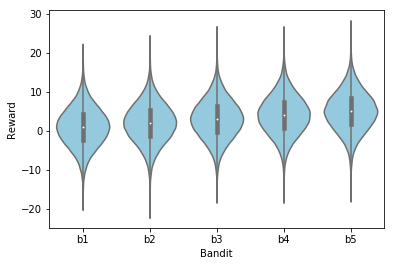

In [5]:
bandits = []
for i in range(1,6):
    bandits.append(Bandit(i, 5))
make_distribution_plot(bandits, n=1e5)

In [6]:
# Plays the bandits n times during t time steps
datas = {}
n = 20
t = 1000
es = [0, 0.01, 0.10]

for e in es:
    # Play n times
    for i in range(n):
        # Get t time-steps of each bandit
        if i == 0:
            data = sample_bandits(bandits, e, t)
        else:
            data = data.append(sample_bandits(bandits, e, t))
            
    datas[e] = data

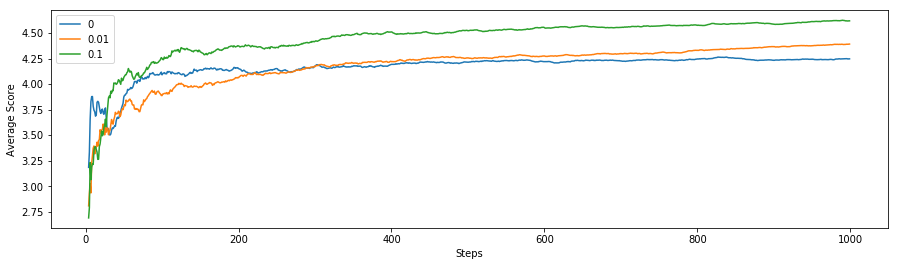

In [7]:
# Plot the average score across time
plt.figure(figsize=(15,4))

# Plot each e separately
for e, data in datas.items():
    data = data.groupby(data.index).mean()
    plt.plot(data.index, data['sample'].expanding(5).mean(), label=e)
plt.xlabel('Steps')
plt.ylabel('Average Score')
plt.legend()
plt.show()

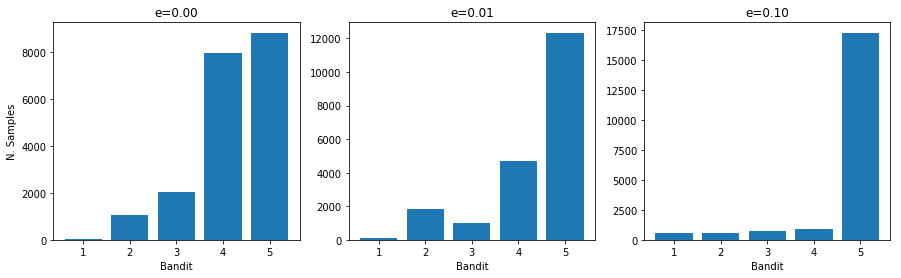

In [8]:
# Plot counts of samples
i = 1
plt.figure(figsize=(15,4))

#Plot each e separately
for e, data in datas.items():
    sample_freq = data.groupby('machine').count()['sample']
    plt.subplot(1, 3, i)
    plt.bar(range(1,6), sample_freq)
    plt.title("e={:.2f}".format(e))
    plt.xlabel('Bandit')
    if i == 1:
        plt.ylabel('N. Samples')
    i += 1
plt.show()

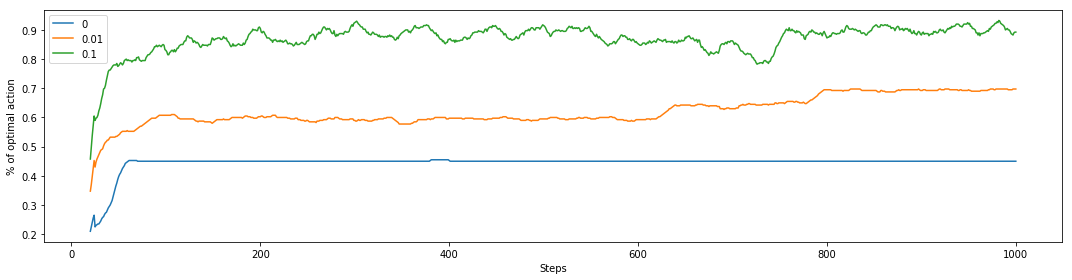

In [9]:
# Plot % of optimal bandit sampling across time across the n times
# and t time steps
plt.figure(figsize=(15,4))

for j, e in enumerate(es):
    d = []
    for i in range(0, n*t, t):
        d.append(datas[e].iloc[i:i+t]['machine'])
        
    # Get the success rate at each time step
    d = np.array((np.matrix(d) == 4).mean(axis=0))[0]
    
    # And plot it with a 20 step moving average
    sns.lineplot(y=pd.DataFrame(d).rolling(20).mean()[0], x=range(1,t+1), label=e)
plt.legend()
plt.ylabel('% of optimal action')
plt.xlabel('Steps')
plt.tight_layout()
plt.show()

# Make bandits non-stationary

In [10]:
def mutate_bandit(bandits, proba):
    '''Changes the mean and std of bandits with a certain probability'''
    for bandit in bandits:
        if np.random.random() < proba:
            bandit.mean += np.random.randint(-100,200)/100
            bandit.std += np.random.randint(-50,75)/100

In [11]:
def non_stationary_play(e, n, t, mutation=0.01, max_=None):
    '''Generates bandits and then plays with them with e exploration probability
    during n episodes of t timesteps. Each bandit has a "mutation" probability of being
    mutated and a maximum memory of max_ is applied.'''
    datas = []
    best_bandits = []
    for i in range(n):
        # Generate bandits
        bandits = []
        for i in range(1,6):
            bandits.append(Bandit(i, 5))
        best_bandit = [4 for _ in bandits]
            
        # Sample each bandit first
        data = sample_bandits(bandits, e, 0, max_=max_)
        
        for j in range(t-len(bandits)):
            # mutate
            mutate_bandit(bandits, mutation)
            # play
            data = sample_bandits(bandits, e, 1, data=data, max_=max_)
            # calculate best bandit
            best_bandit.append(np.argmax([b.mean for b in bandits]))
    
        datas.append(data)
        best_bandits.append(best_bandit)
    return datas, best_bandits

In [12]:
successes = {}
for e in es:
    datas, best_bandits = non_stationary_play(e, 20, 1000, 0.01, 50)

    success = []
    for i in range(len(datas)):
        success.append(datas[i]['machine'] == best_bandits[i])
    success = np.array(np.matrix(success).mean(axis=0))[0]
    successes[e] = success 
    print('e = {} ready!'.format(e))

e = 0 ready!
e = 0.01 ready!
e = 0.1 ready!


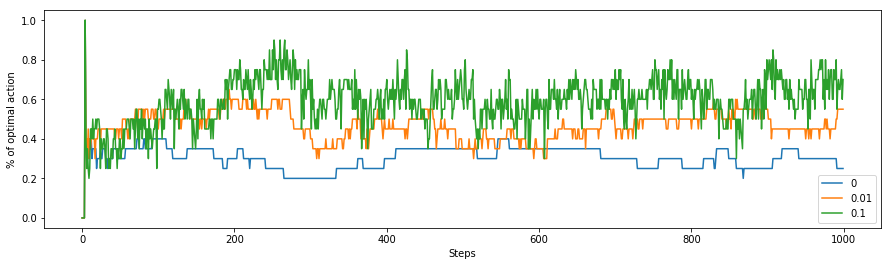

In [13]:
plt.figure(figsize=(15,4))
for e, s in successes.items():
    plt.plot(s, label=e)
plt.legend()
plt.ylabel('% of optimal action')
plt.xlabel('Steps')
plt.show()